In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# 3. Fitting Circles

(2431, 2)


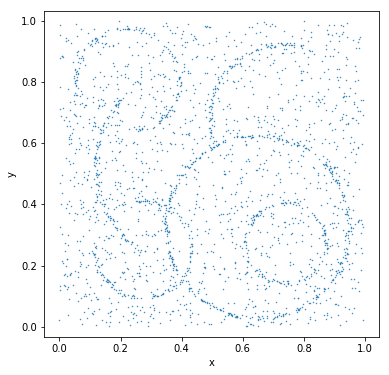

In [2]:
data = np.load('circles.npy')
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=0.2)
ax.axis('equal')
ax.set_xlabel('x'); ax.set_ylabel('y')
print(data.shape)

## 3.1 RANSAC

For the RANSAC algorithm we need to find center and radius of a circle from 3 points. We can transform the circle equation to a system of linear equations:

$$ (x_i - x_c)^2 + (y_i -y_c)^2 = R^2 \quad \text{for } i \in \{1,2,3\} \text{ and } x_c,y_c \text{ center coordinates}$$

$$ \Rightarrow x_i^2 - 2x_i x_c + x_c^2 + y_i^2 - 2y_i y_c + y_c^2 = R$$

$$ \Rightarrow x_1^2 - 2x_1 x_c + y_1^2 - 2y_1 y_c = x_2^2 - 2x_2 x_c + y_2^2 - 2y_2 y_c = x_3^2 - 2x_i x_c + y_3^2 - 2y_3 y_c$$

Now create linear system from first half of this equation:

$$x_1^2 - 2x_1 x_c + y_1^2 - 2y_1 y_c = x_2^2 - 2x_2 x_c + y_2^2 - 2y_2 y_c$$

$$ \Rightarrow 2(x_1-x_2)x_c + 2(y_1-y_2)y_c = x_1^2 + y_1^2 - x_2^2 - y_2^2 $$

And the same from the right hand side:

$$x_2^2 - 2x_2 x_c + y_2^2 - 2y_2 y_c = x_3^2 - 2x_3 x_c + y_3^2 - 2y_3 y_c$$

$$ \Rightarrow 2(x_2-x_3)x_c + 2(y_2-y_3)y_c = x_2^2 + y_2^2 - x_3^2 - y_3^2 ​$$

From these two results we can create the linear system:

$$ \begin{pmatrix} 2(x_1-x_2) & 2(y_1-y_2)  \\ 2(x_2-x_3) & 2(y_2-y_3) \end{pmatrix} \begin{pmatrix} x_c \\ y_c \end{pmatrix} = \begin{pmatrix} x_1^2 + y_1^2 - x_2^2 - y_2^2 \\ x_2^2 + y_2^2 - x_3^2 - y_3^2 \end{pmatrix} $$

We can just solve this system easily and get the center coordinates. If the matrix is not regular, there is no unique solution, and the RANSAC step is just ignored.

To get the radius from the center coordinates using the circle equation and one of the three points:

$$ R = \sqrt{(x_i - x_c)^2 + (y_i -y_c)^2} $$

In [254]:
def circle_3point(p):
    "Fit circle to 3 points"
    # create linear system
    A = np.array([[2 * (p[0,0]-p[1,0]), 2*(p[0,1]-p[1,1])],
                  [2 * (p[1,0]-p[2,0]), 2*(p[1,1]-p[2,1])]])
    b = np.array([p[0,0]**2 + p[0,1]**2 - p[1,0]**2 - p[1,1]**2,
                  p[1,0]**2 + p[1,1]**2 - p[2,0]**2 - p[2,1]**2])
    # solve linear system
    center = np.linalg.solve(A, b)
    R = np.linalg.norm(p[0] - center)
    return center, R

In [255]:
def ransac_single(data, N, eps):
    center_best, r_best = np.zeros(2), 0
    inlier_count_best = 0
    eps2 = eps**2
    for _ in range(N):
        # select 3 random points and fit circle to it
        p_ind = np.random.randint(data.shape[0], size=3)
        try:
            center, r = circle_3point(data[p_ind])
        except np.linalg.LinAlgError:
            # if no unique solution for circle, ignore step
            continue
        # find inliers of circle: R - eps < ||p - center|| < R + eps
        dist2 = (data[:,0] - center[0])**2 + (data[:,1] - center[1])**2
        inliers = abs(dist2 - r**2) < eps2
        inlier_count = np.count_nonzero(inliers)
        # save circle and inlier if best up to this point
        if inlier_count > inlier_count_best:
            center_best, r_best = center, r
            inliers_best = inliers
            inlier_count_best = inlier_count
    # if no circle was found, return None
    if r_best == 0:
        return None, None, None
    else:
        return center_best, r_best, inliers_best

In [257]:
def ransac_multi(data, N_circles, N_ransac, eps, fit_circle=(lambda d,i,c,r:(c,r))):
    circles = []
    inlier_all = np.zeros(data.shape[0], dtype=bool)
    for _ in range(N_circles):
        center, r, inlier = ransac_single(data, N_ransac, eps)
        if r is None or inlier.shape[0] - np.count_nonzero(inlier) == 0:
            break
        # fit circle to inliers
        # if fit_circles not explicitly given, use r, center from 3 points in RANSAC
        circles.append(fit_circle(data, inlier, center, r))
        # remove inliers from dataset for next step
        data = data[~inlier]
        # keep track of all inliers
        inlier_all[~inlier_all] = inlier
    return circles, inlier_all

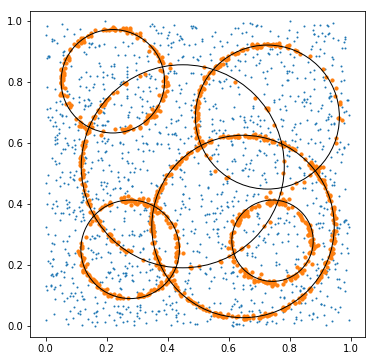

In [258]:
circles, inlier = ransac_multi(data, 6, N_ransac=10000, eps=0.07)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=1, label='All data')
ax.scatter(data[inlier,0], data[inlier,1], s=10, label='Outlier')
for center, r in circles:
    ax.add_patch(plt.Circle(center, r, fill=False))
ax.axis('equal');

## 3.2 Algebraic Distance

To get a better circle fit to the inliers found with RANSAC we minimize the algebraic distance: (inlier $x_i$, center coordinates $c$, radius $r$)

$$
\hat c, \hat r = \underset{c, r}{\operatorname{argmin}} \sum_i (\|x_i - c \|^2-r^2)^2  = \underset{c, r}{\operatorname{argmin}} \sum_i ((x_i - c )^T(x_i - c )-r^2)^2 = \underset{c, r}{\operatorname{argmin}} \sum_i (x_i^T x_i - 2c^T x_i + c^T c - r^2)^2
$$

Now we move to augmented space and define $\tilde x$, $\tilde{y}$ and $\beta$:

$$ \tilde{x}  = \begin{pmatrix} x_{i1} & x_{i2} &  1 \end{pmatrix} $$

$$ \tilde{y} = x_i^T x_i $$

$$\beta = \begin{pmatrix} 2c_1 \\ 2c_2 \\ r^2-c^T c \end{pmatrix}$$
$$
\Rightarrow \tilde{x} \cdot \beta = 2x_{i1}c_1 + 2x_{i2}c_2 + r^2 - c^T c = 2 c^T x_i - c^T c + r^2
$$
With these definitions we can now minimize
$$
\hat{\beta} = \underset{\beta}{\operatorname{argmin}} \sum_i (\tilde{y} -\tilde{x}_i \beta)^2
$$
using the least-squares method. From $\hat{\beta}$ we get our circle parameters back easily with $c_1 = \hat{\beta}_1$, $c_2 = \hat{\beta}_2 $ , $ r = \sqrt{\hat{\beta}_3 + c^T c}$

In [248]:
def algebraic_distance(data, inlier, c=None,r=None):
    # ggo to augmented space
    data = data[inlier]
    x = np.hstack((data, np.ones((data.shape[0],1))))
    y = np.sum(np.square(data), axis=1)
    beta = np.linalg.lstsq(x, y)[0]
    center = beta[:2] / 2
    r = np.sqrt(beta[2] + np.sum(np.square(center)))
    return center, r

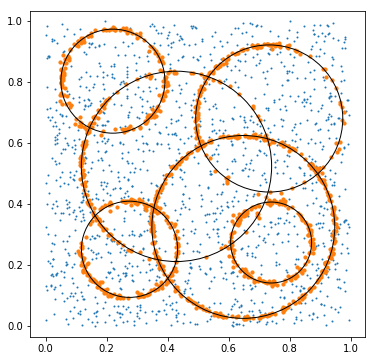

In [252]:
circles, inlier = ransac_multi(data, 6, N_ransac=10000, eps=0.07, fit_circle=algebraic_distance)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=1, label='All data')
ax.scatter(data[inlier,0], data[inlier,1], s=10, label='Outlier')
for center, r in circles:
    ax.add_patch(plt.Circle(center, r, fill=False))
ax.axis('equal');

## 3.3 Levenberg-Marquardt

In [ ]:
center, r, inlier = ransac_single(data, 10000, 0.07)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=1, label='All data')
ax.scatter(data[inlier,0], data[inlier,1], s=10, label='Outlier')
ax.add_patch(plt.Circle(center, r, fill=False))
ax.add_patch(plt.Circle(*algebraic_distance(data, inlier), fill=False))
ax.axis('equal')
print(center, r)

## 3.4 Comparison